In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import scipy.stats as stats
#Test estadistico sobre la normalidad de los residuos
from scipy.stats import shapiro


In [2]:
channel_name = "channel_1055"
df = pd.read_csv(f'../../datasets/{channel_name}.csv', index_col="Timestamp", parse_dates=True)

FileNotFoundError: [Errno 2] No such file or directory: '../../datasets/channel_1055.csv'

In [ ]:
df.head()

,channel_1055,Unit_measure,Subsystem
Timestamp,,,
2025-01-01 00:00:00,0.496714,UnitMeasure5,Subsystem1
2025-01-01 00:00:30,0.904835,UnitMeasure5,Subsystem1
2025-01-01 00:01:00,1.698462,UnitMeasure5,Subsystem1
2025-01-01 00:01:30,3.863408,UnitMeasure5,Subsystem1
2025-01-01 00:02:00,5.621446,UnitMeasure5,Subsystem1


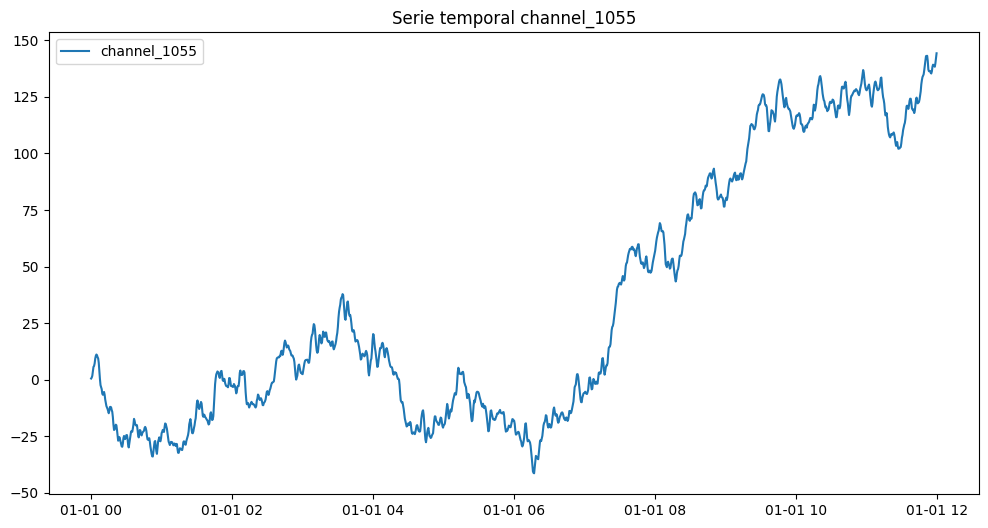

In [169]:
plt.figure(figsize=(12,6))
plt.plot(df["channel_1055"], label=channel_name)
plt.title(f'Serie temporal {channel_name}')
plt.legend()
plt.show()



¿Hay nulos?

In [170]:
#Si, columnas hay una sola, pero lo dejamos genérico para otros casos
for c in df.columns:
    print(f"{c}: {df[c].isnull().sum()} nulos")

channel_1055: 0 nulos
Unit_measure: 0 nulos
Subsystem: 0 nulos


¿Hay duplicados?

In [171]:
df.index.duplicated().any() 

False

¿La periodicidad es estable?

In [172]:
df_time_diffs = df.index.to_series().diff().dt.total_seconds()  
print(df_time_diffs.value_counts())

Timestamp
30.0    1353
60.0      43
Name: count, dtype: int64


---------------------

### 1. Si la periodicidad no es estable, resolver



### 2. ¿Tiene la serie propiedades para poder aplicar un modelo estadístico? Si no las tiene resolver.

### 3. ¿Puede encontrar un modelo que supere el pronostico ingenuo que agregamos a continuación?

### 4. Si intenta una búsqueda de órden p y q ¿Puede restringir al menos un poco las opciones de búsqueda?